# Injecting and Measuring Artificial Stars in Single-Visit Images

Jeff Carlin <br>
Last verified to run Monday, April 26, 2022, with weekly 2022_12.

Recommended container size: large (or possibly medium; small will definitely run out of memory and kill the kernel).

This tutorial demonstrates a method to inject artificial stars into `calexp` images using the measured point-spread function of the given `calexp` image. It then shows how to run the pipelines' detection and measurement tasks on these images, extract the measurements of the artificial stars, and compare their measured magnitudes to the input (simulated) magnitudes.

#### Prerequisites

This tutorial assumes familiarity with afwDisplay, the Butler, and source detection with the LSST Science Pipelines.
Relevant tutorials can be found in the <a href="https://github.com/rubin-dp0/tutorial-notebooks">rubin-dp0/tutorial-notebooks</a> repository.
(For image display, see NBs 03a, 03b, and 08a; for the Butler, see NB 04; and for source detection, see NB 05).

## Introduction

This tutorial shows a way to use existing tools in the LSST Science Pipelines to inject artificial stars into processed single-visit images ("calexps"), then run the detection and measurement tasks to test the recovery of these stars and their (known) properties. In this particular notebook, the focus is on inserting _stars_ into the images because that is the simplest operation (requiring only a position and a flux/magnitude). However, the tools do exist to insert simulated galaxies (based on parameters describing their light distribution), or to insert images (for example, an image of a simulated galaxy cluster) into processed data. See <a href="https://community.lsst.org/t/new-tasks-for-fake-source-insertion/3722">this post</a> on the Community forum for an introduction to the current fake source injection tasks.

**NOTE**: The task that is used in this notebook to create fake stars will soon be deprecated and removed from the Science Pipelines, and its replacement tasks (discussed in the Community forum post linked above) will also soon be replaced with refactored and improved tasks. Once the new synthetic source code has arrived, this notebook should be updated to use the newer tasks.

<br>


The workflow in this notebook is as follows:

1. Starting with an RA, Dec position, find all single-visit images that overlap that position.
    - (For this tutorial, we select only a single visit image from each band.)
2. Given positions and input magnitudes for fake stars (in _ugri_ bands), figure out what the X, Y positions and fluxes should be in each image.
3. Inject those stars into the appropriate images with the X, Y positions and fluxes as calculated in the previous step, using the measured PSF for each individual image to create stellar images.
4. Run all processing steps (characterization, calibration, detection, deblending, measurement) on each image that fake stars were inserted into.
5. Compare the measured positions and fluxes/mags to the input synthetic values.

## Set Up

#### Import packages.

In [4]:
# Import python packages
import time
import os
import warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import IFrame, display, Markdown
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
from astropy.visualization import ZScaleInterval
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

%matplotlib inline

In [5]:
# Import tasks from the LSST Science Pipelines for reprocessing images
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate import CalibrateTask
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.deblender import SourceDeblendTask
from lsst.meas.base import SingleFrameMeasurementTask

In [6]:
# Import LSST Science Pipelines packages (see pipelines.lsst.io)
import lsst.daf.base as dafBase
from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom
import lsst.pipe.tasks.fakes as fakes

# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib')

In [7]:
# Set up some plotting defaults:

params = {'axes.labelsize': 28,
          'font.size': 24,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [9, 9],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

#### Instantiate the Butler.

In [8]:
# For DC2 gen3, these are the only optoins
repo = 's3://butler-us-central1-dp01'
collection = '2.2i/runs/DP0.1'

butler = Butler(repo, collections=collection)
registry = butler.registry

#### Create a list of artificial stars to inject: 

To inject artificial stars, all that is needed is a list of RA, Dec positions, and magnitudes to assign the simulated stars.

We will generate `nfakes` stars with positions randomly distributed (using a normal distribution of size `scatter_arcmin` in arcminutes) about the center coordinate (racen, deccen). The stars will be evenly spaced in u-band magnitude (i.e., in `nfakes` equal intervals between magmin and magmax), and randomly distributed about a mean color for each band. (I chose to use a fixed mean color for all stars for simplicity, but apply a normally-distributed scatter of `mag_scatter` magnitudes about this mean value so they are not all identical.)


In [9]:
# Central (RA, Dec) position (in degrees) at which to insert stars:
racen = 70.3
deccen = -37.15

# Place all the fake stars within `scatter_arcmin` arcminutes of the center coordinate:
scatter_arcmin = 1.0

# "nfakes" is the number of fake stars to inject:
nfakes = 31

# Assign positions using a (random) normal distribution about the center coordinates:
fake_ras = racen + (np.random.randn(nfakes) * scatter_arcmin / 60.0)
fake_decs = deccen + (np.random.randn(nfakes) * scatter_arcmin / 60.0)

# Make artificial u magnitudes in a range:
min_umag = 18.0
max_umag = 22.0
mag_scatter = 0.3
fake_umags = np.linspace(min_umag, max_umag, nfakes)

# Now assign magnitudes in other bands using (~fixed) colors:
fake_gmags = fake_umags - (1.0 + mag_scatter * np.random.randn(nfakes))  # distrib centered on u-g=1.0
fake_rmags = fake_gmags - (0.4 + mag_scatter * np.random.randn(nfakes))  # distrib centered on g-r=0.4
fake_imags = fake_rmags - (0.2 + mag_scatter * np.random.randn(nfakes))  # distrib centered on r-i=0.2

# These are totally arbitrary colors, but should be kinda similar to BHB stars?

In [10]:
print(fake_ras, fake_decs, fake_gmags)

[70.27083109 70.3118815  70.28066891 70.31531676 70.30917639 70.30901959
 70.29686867 70.27884021 70.29908111 70.29998994 70.31231681 70.27914295
 70.30840727 70.31783679 70.31353263 70.30182059 70.3016401  70.2901206
 70.29767983 70.29950944 70.30692615 70.31542146 70.2995848  70.2942113
 70.29895681 70.31180226 70.29188228 70.27360008 70.30485454 70.29442807
 70.3122833 ] [-37.17405915 -37.13050298 -37.1616483  -37.13879925 -37.13557526
 -37.13363729 -37.11999795 -37.16699877 -37.15844414 -37.13582423
 -37.15561299 -37.15375847 -37.15359718 -37.15498582 -37.15051827
 -37.16009921 -37.14616527 -37.16764564 -37.13917398 -37.14338078
 -37.14993801 -37.16709422 -37.15748679 -37.16411456 -37.14471106
 -37.17905671 -37.1396685  -37.15596334 -37.15245786 -37.14916796
 -37.15410555] [16.9751478  17.25021615 16.96317355 17.00663966 17.63283635 17.73379134
 17.67657072 17.39172003 18.08939577 18.79204109 18.60374075 18.33975478
 18.52782832 18.56149883 18.9150461  18.72011031 19.59290154 19.08

### Look up the images that overlap the desired coordinates

We will use the spatial query method introduced in [notebook 04: Intro to the Butler](https://github.com/rubin-dp0/tutorial-notebooks/blob/main/04_Intro_to_Butler.ipynb).

In [11]:
import lsst.sphgeom

pixelization = lsst.sphgeom.HtmPixelization(12)

In [12]:
htm_id = pixelization.index(
    lsst.sphgeom.UnitVector3d(
        lsst.sphgeom.LonLat.fromDegrees(racen, deccen)
    )
)

# Obtain and print the scale to provide a sense of the size of the sky pixelization being used
scale = pixelization.triangle(htm_id).getBoundingCircle().getOpeningAngle().asDegrees()*3600
print(f'HTM ID={htm_id} at level={pixelization.getLevel()} is a ~{scale:0.2}" triangle.')

HTM ID=147743564 at level=12 is a ~6.8e+01" triangle.


#### Now query the registry for all "calexp" images overlapping the desired position:

In [13]:
datasetRefs = registry.queryDatasets("calexp", htm20=htm_id)

print("Found ", datasetRefs.count(), " calexps at that position.")

Found  555  calexps at that position.


That's nice, but it finds images from all bands overlapping the position in a single iterator. Let's get lists separately for each band:

In [14]:
datasetRefs_u = registry.queryDatasets("calexp", htm20=htm_id, band="u")
datasetRefs_g = registry.queryDatasets("calexp", htm20=htm_id, band="g")
datasetRefs_r = registry.queryDatasets("calexp", htm20=htm_id, band="r")
datasetRefs_i = registry.queryDatasets("calexp", htm20=htm_id, band="i")

print("Found ", datasetRefs_u.count(), " u-band calexps at that position.")
print("Found ", datasetRefs_g.count(), " g-band calexps at that position.")
print("Found ", datasetRefs_r.count(), " r-band calexps at that position.")
print("Found ", datasetRefs_i.count(), " i-band calexps at that position.")

Found  33  u-band calexps at that position.
Found  63  g-band calexps at that position.
Found  141  r-band calexps at that position.
Found  138  i-band calexps at that position.


For now, let's just grab the first image in the list for each band.

In [15]:
for i, ref in enumerate(datasetRefs_u):
    uref = ref
    if i > 0:
        break

for i, ref in enumerate(datasetRefs_g):
    gref = ref
    if i > 0:
        break

for i, ref in enumerate(datasetRefs_r):
    rref = ref
    if i > 0:
        break

for i, ref in enumerate(datasetRefs_i):
    iref = ref
    if i > 0:
        break


What does that `datasetRef` object look like?

In [16]:
iref

DatasetRef(DatasetType('calexp', {band, instrument, detector, physical_filter, visit_system, visit}, ExposureF), {instrument: 'LSSTCam-imSim', detector: 5, visit: 924041, ...}, id=3a557ef0-1f3b-41ff-9aa7-5ef1fea20fac, run='2.2i/runs/DP0.1/calexp/v1')

### Make stars and inject them into images:

First, write a function ("makeFakeStar") that takes as inputs the position, flux (intensity), and the PSF, and returns an image of the PSF scaled to the desired flux at the input position.

Next, we add a function ("addFakeStars") that takes the list of RAs, Decs, and magnitudes, and a `datasetRef` for a `calexp` image, and returns a version of the input `calexp` that has the fake stars injected into it. (This function calls "makeFakeStar" for each star in the list.)

The source injection steps were developed following this piece of code as an example: https://github.com/lsst/pipe_tasks/blob/387f8f07a2b66205f9fa6bda9a89dcdbbef3f64c/tests/test_fakeProcessing.py

In [17]:
# make stars at a given position with a given intensity
def makeFakeStar(position, intensity, psf):
    psfImage = psf.computeImage(geom.Point2D(position.x, position.y)).getArray()
    psfImage *= intensity
    noise = np.random.normal(0, np.sqrt(abs(psfImage)))
    return psfImage + noise, noise

In [18]:
def addFakeStars(ras, decs, mags, calexp_ref):
    calexp_inp = butler.get('calexp', calexp_ref.dataId)
    calexp_withFakes = calexp_inp.clone()

    # Fetch objects from the exposure
    psf = calexp_withFakes.getPsf()
    image = calexp_withFakes.getMaskedImage().getImage()
    variance = calexp_withFakes.getMaskedImage().getVariance()
    wcs = calexp_withFakes.getWcs()
    photocalib = calexp_withFakes.getPhotoCalib()

    fluxes = []

    # Use the "photocalib" from the calexp to convert magnitudes to instrumental fluxes:
    for mag in mags:
        fluxes.append(photocalib.magnitudeToInstFlux(mag))

    # Get the corner coordinates of the image:
    y0 = image.getY0()
    x0 = image.getX0()
    ymax = y0 + calexp_withFakes.getDimensions()[1]
    xmax = x0 + calexp_withFakes.getDimensions()[0]

    #xvals = []
    #yvals = []
    
    # At each position create a star with the given intensity and add it
    # to the image.
    for ra, dec, intensity in zip(ras, decs, fluxes):
        # Use the WCS to convert RA, Dec to X, Y pixel coordinates:
        pos = wcs.skyToPixel(geom.SpherePoint(ra, dec, geom.degrees))
        #xvals.append(pos.x)
        #yvals.append(pos.y)

        # Call "makeFakeStar" to get the image of a PSF-like object with the desired flux:
        objArray, noiseArray = makeFakeStar(pos, intensity, psf)
        psfRad = int((objArray.shape[0]-1)/2.)

        # Check that the desired position is within the image:
        oky = (pos.y > psfRad) & (pos.y < ymax - psfRad)
        okx = (pos.x > psfRad) & (pos.x < xmax - psfRad)

        if okx & oky:
            yslice = slice(int(np.floor(pos.y - psfRad - y0)), int(np.floor(pos.y + psfRad + y0 + 1)))
            xslice = slice(int(np.floor(pos.x - psfRad - x0)), int(np.floor(pos.x + psfRad + x0 + 1)))

            print('Injecting source at x, y = ', pos.x, pos.y)

            # NOTE: while image arrays are indexed with x, y, the extraction of the data into (numpy) arrays
            # means that the returned arrays follow numpy's y, x convention.
            # More on indexing: https://pipelines.lsst.io/modules/lsst.afw.image/indexing-conventions.html
            image.getArray()[yslice, xslice] += objArray
            variance.getArray()[yslice, xslice] += noiseArray**2
        else:
            print('Skipped injecting source at x, y = ', pos.x, pos.y, ' because it is too close to (or off) the edge.')

    return calexp_inp, calexp_withFakes

### Call the "addFakeStars" function to create calexp images with the artificial stars injected:

In [19]:
calexp_orig_u, calexp_new_u = addFakeStars(fake_ras, fake_decs, fake_umags, uref)
calexp_orig_g, calexp_new_g = addFakeStars(fake_ras, fake_decs, fake_gmags, gref)
calexp_orig_r, calexp_new_r = addFakeStars(fake_ras, fake_decs, fake_rmags, rref)
calexp_orig_i, calexp_new_i = addFakeStars(fake_ras, fake_decs, fake_imags, iref)

Injecting source at x, y =  274.29186051447596 1244.6587185266292
Injecting source at x, y =  1213.5636584099457 1525.8136184930213
Injecting source at x, y =  532.7178194154749 1299.6632393452583
Injecting source at x, y =  1090.3428660437871 1623.8222264462606
Injecting source at x, y =  1114.4495209463475 1520.9955033956523
Injecting source at x, y =  1146.4274978476674 1506.7984034874376
Injecting source at x, y =  1316.8009539623922 1258.0071219190663
Injecting source at x, y =  433.2509984643857 1308.429206391511
Injecting source at x, y =  678.0015340372088 1527.6308318160595
Injecting source at x, y =  1064.7764778839028 1398.78549809704
Injecting source at x, y =  791.3349085206223 1688.237168168942
Injecting source at x, y =  658.4880941952308 1229.8732645456046
Injecting source at x, y =  806.0614804404199 1623.0115841805214
Injecting source at x, y =  829.2392967932662 1758.6751218654972
Injecting source at x, y =  883.4531649320636 1672.8500144051186
Injecting source at x,

### Wrap all of the detection and measurement steps in a function.

The steps here follow the <a href="https://github.com/rubin-dp0/tutorial-notebooks/blob/main/05_Intro_to_Source_Detection.ipynb">Intro to Source Detection</a> tutorial notebook, so rather than explain them in detail here, we simply wrap all the steps in a single function that can be executed for each image.

In [20]:
def processFakes(calexp_inp):
    
    # Create a basic schema to use with these tasks
    schema = afwTable.SourceTable.makeMinimalSchema()

    # Create a container which will be used to record metadata about algorithm execution
    algMetadata = dafBase.PropertyList()

    # Initialize CharacterizeImageTask and its configuration:
    config = CharacterizeImageTask.ConfigClass()
    config.psfIterations = 1
    charImageTask = CharacterizeImageTask(None, config=config)

    # Initialize SourceDetectionTask and its configuration:
    config = SourceDetectionTask.ConfigClass()
    config.thresholdValue = 10      # detection threshold in units of thresholdType
    config.thresholdType = "stdev"   # units for thresholdValue
    sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
    sourceDeblendTask = SourceDeblendTask(schema=schema)

    # Initialize SingleFrameMeasurementTask and its configuration:
    config = SingleFrameMeasurementTask.ConfigClass()
    sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config, algMetadata=algMetadata)

    # Make an empty table that we'll put the results in:
    tab = afwTable.SourceTable.make(schema)
    
    # Image characterization
    result = charImageTask.run(calexp_inp)

    # Get the PSF and some image properties
    psf = calexp_inp.getPsf()
    sigma = psf.computeShape().getDeterminantRadius()
    pixelScale = calexp_inp.getWcs().getPixelScale().asArcseconds()

    # The factor of 2.355 converts from std to fwhm
    print('psf fwhm = {:.2f} arcsec'.format(sigma*pixelScale*2.355))
    
    # Run source detection
    result = sourceDetectionTask.run(tab, calexp_inp)
    
    sources = result.sources
    
    # Run source deblending
    sourceDeblendTask.run(calexp_inp, sources)

    # Run source measurement
    sourceMeasurementTask.run(measCat=sources, exposure=calexp_inp)

    # The copy makes sure that the sources are sequential in memory
    sources = sources.copy(True)
    
    # For convenience, return an Astropy table:
    source_tab = sources.asAstropy()
    
    # Convert fluxes to magnitudes and add them to the table
    photocalib = calexp_inp.getPhotoCalib()
    psfmags = photocalib.instFluxToMagnitude(sources, 'base_PsfFlux')
    source_tab.add_columns([psfmags[:,0], psfmags[:,1]], names=['mag_psf', 'magerr_psf'])
    
    return(source_tab)

### Run the "processFakes" function on each image that we injected fake stars into

**This may take at least a couple minutes to run**

In [21]:
t1 = time.time()

sources_withfakes_u = processFakes(calexp_new_u)
sources_withfakes_g = processFakes(calexp_new_g)
sources_withfakes_r = processFakes(calexp_new_r)
sources_withfakes_i = processFakes(calexp_new_i)

t2 = time.time()
print('dt', t2 - t1)

/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


/tmp/ipykernel_4617/125701312.py:33: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


psf fwhm = 0.94 arcsec


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_deblender/g359a236c20+bf72eb646d/python/lsst/meas/deblender/sourceDeblendTask.py:281: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  return psf.computeShape().getDeterminantRadius() * 2.35


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


/tmp/ipykernel_4617/125701312.py:33: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


psf fwhm = 0.78 arcsec


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_deblender/g359a236c20+bf72eb646d/python/lsst/meas/deblender/sourceDeblendTask.py:281: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  return psf.computeShape().getDeterminantRadius() * 2.35


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


/tmp/ipykernel_4617/125701312.py:33: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


psf fwhm = 1.28 arcsec


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_deblender/g359a236c20+bf72eb646d/python/lsst/meas/deblender/sourceDeblendTask.py:281: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  return psf.computeShape().getDeterminantRadius() * 2.35


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:77: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  psfSigma = psfModel.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/installGaussianPsf.py:78: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  width, height = psfModel.computeImage().getDimensions()


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


/tmp/ipykernel_4617/125701312.py:33: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:410: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_algorithms/gbe01a4569f+b284e5e768/python/lsst/meas/algorithms/detection.py:447: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  sigma = psf.computeShape().getDeterminantRadius()


psf fwhm = 0.93 arcsec


/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-3.0.0/Linux64/meas_deblender/g359a236c20+bf72eb646d/python/lsst/meas/deblender/sourceDeblendTask.py:281: FutureWarning: Default position argument overload is deprecated and will be removed in version 24.0.  Please explicitly specify a position.
  return psf.computeShape().getDeterminantRadius() * 2.35


dt 74.07917475700378


In [22]:
# Take a look at the catalog:

sources_withfakes_i

id,coord_ra,coord_dec,parent,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,deblend_peak_center_x,deblend_peak_center_y,deblend_peakId,deblend_nPeaks,deblend_parentNPeaks,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_LocalBackground_flag_badCentroid_resetToPeak,base_NaiveCentroid_flag_badInitialCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,base_Variance_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_LocalBackground_flag_badCentroid_badError,base_NaiveCentroid_flag_badInitialCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,base_Variance_flag_badCentroid_badError,slot_Centroid_flag_badError,base_Blendedness_old,base_Blendedness_raw,base_Blendedness_raw_child_instFlux,base_Blendedness_raw_parent_instFlux,base_Blendedness_abs,base_Blendedness_abs_child_instFlux,base_Blendedness_abs_parent_instFlux,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_x

### Match coordinates from the original list of fake stars to the new catalog:

In [23]:
# Coordinates of input fake stars
sc_fakes = SkyCoord(ra=fake_ras*u.deg, dec=fake_decs*u.deg, frame='icrs')

# Coordinates of objects in calexps with fakes added:
sc_withfakes_u = SkyCoord(ra=sources_withfakes_u['coord_ra'], dec=sources_withfakes_u['coord_dec'], frame='icrs')
sc_withfakes_g = SkyCoord(ra=sources_withfakes_g['coord_ra'], dec=sources_withfakes_g['coord_dec'], frame='icrs')
sc_withfakes_r = SkyCoord(ra=sources_withfakes_r['coord_ra'], dec=sources_withfakes_r['coord_dec'], frame='icrs')
sc_withfakes_i = SkyCoord(ra=sources_withfakes_i['coord_ra'], dec=sources_withfakes_i['coord_dec'], frame='icrs')
# Note that units weren't required for sc_withfakes_*, because it already has them.

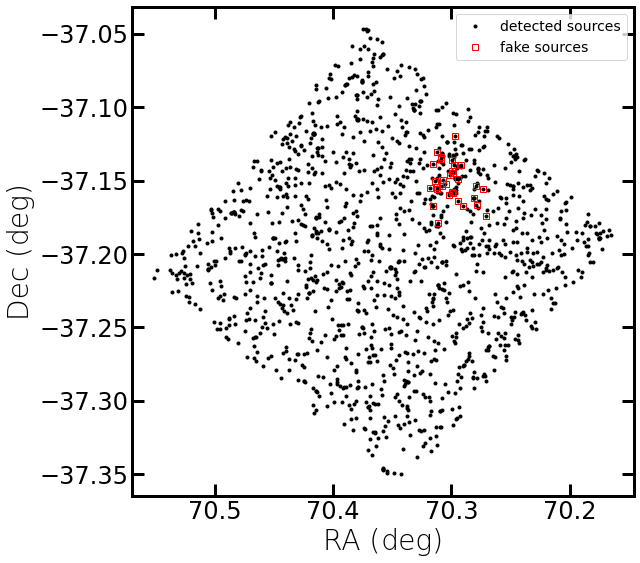

In [24]:
fig, ax = plt.subplots(1, 1)
plt.plot(sc_withfakes_g.ra, sc_withfakes_g.dec, '.k', label='detected sources')
plt.plot(sc_fakes.ra, sc_fakes.dec, 'sr', fillstyle='none', label='fake sources')
ax.invert_xaxis()
plt.legend()
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.show()

In [25]:
# Match them using the Astropy SkyCoord "match_to_catalog_sky" method:

idx_u, sep_u, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_u)
idx_g, sep_g, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_g)
idx_r, sep_r, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_r)
idx_i, sep_i, _ = sc_fakes.match_to_catalog_sky(sc_withfakes_i)

The "idx*" arrays are the indices into sc_withfakes* files to extract the closest match, and "sep*" are the actual separations between the sources. Note that this returns a separation for all objects -- in the following, we will keep only sources with match separations less than 1 arcsecond (i.e., "good" matches).

Extract info about the good matches into arrays:

In [26]:
okmch_u = (sep_u.arcsec < 1.0)
mch_mags_u = sources_withfakes_u[idx_u]['mag_psf']
mch_magerrs_u = sources_withfakes_u[idx_u]['magerr_psf']
# If the nearest match is >1" away, set its magnitudes to -99.9:
mch_mags_u[~okmch_u] = -99.9
mch_magerrs_u[~okmch_u] = 99.9
seps_u = sep_u.arcsec

okmch_g = (sep_g.arcsec < 1.0)
mch_mags_g = sources_withfakes_g[idx_g]['mag_psf']
mch_magerrs_g = sources_withfakes_g[idx_g]['magerr_psf']
mch_mags_g[~okmch_g] = -99.9
mch_magerrs_g[~okmch_g] = 99.9
seps_g = sep_g.arcsec

okmch_r = (sep_r.arcsec < 1.0)
mch_mags_r = sources_withfakes_r[idx_r]['mag_psf']
mch_magerrs_r = sources_withfakes_r[idx_r]['magerr_psf']
mch_mags_r[~okmch_r] = -99.9
mch_magerrs_r[~okmch_r] = 99.9
seps_r = sep_r.arcsec

okmch_i = (sep_i.arcsec < 1.0)
mch_mags_i = sources_withfakes_i[idx_i]['mag_psf']
mch_magerrs_i = sources_withfakes_i[idx_i]['magerr_psf']
mch_mags_i[~okmch_i] = -99.9
mch_magerrs_i[~okmch_i] = 99.9
seps_i = sep_i.arcsec

#print(fake_imags[okmch], sources_withfakes_i[idx_i[okmch]]['mag_psf'])

In [27]:
sep_g.arcsec

array([2.81717514e-01, 2.82184544e-01, 9.52499134e-04, 2.82704598e-01,
       2.82621509e-01, 1.99449886e-01, 1.99333819e-01, 2.00254294e-01,
       1.98731256e-01, 2.28313699e-03, 1.98016856e-01, 2.00099623e-01,
       1.62886536e-03, 2.00890445e-01, 2.30085810e-03, 6.77335355e-04,
       3.20020505e-03, 1.15512964e-03, 1.99946331e-01, 3.86171298e-03,
       1.17421657e-03, 1.99808736e-01, 2.17783483e-03, 2.82608098e-04,
       1.80537041e-01, 2.03276130e-01, 1.09340693e-03, 1.99558882e-01,
       1.86172536e+00, 3.93447023e-03, 2.02580998e-01])

Combine all of the information into a single table:

In [28]:
tab_all = Table([fake_ras, fake_decs, fake_umags, fake_gmags, fake_rmags, fake_imags,
                 mch_mags_u, mch_magerrs_u, seps_u, mch_mags_g, mch_magerrs_g, seps_g,
                 mch_mags_r, mch_magerrs_r, seps_r, mch_mags_i, mch_magerrs_i, seps_i],
                 names=['ra', 'dec', 'u_fake', 'g_fake', 'r_fake', 'i_fake', 'u_meas', 'uerr_meas', 'sep_u',
                        'g_meas', 'gerr_meas', 'sep_g', 'r_meas', 'rerr_meas', 'sep_r',
                        'i_meas', 'ierr_meas', 'sep_i'],
                 units=[u.deg, u.deg, u.mag, u.mag, u.mag, u.mag, u.mag, u.mag, u.arcsec,
                        u.mag, u.mag, u.arcsec, u.mag, u.mag, u.arcsec, u.mag, u.mag, u.arcsec])

for col in tab_all.colnames[0:2]:
    tab_all[col].info.format = '%.8g'  # for consistent table output
for col in tab_all.colnames[2:]:
    tab_all[col].info.format = '%.5g'  # for consistent table output


In [29]:
tab_all

ra,dec,u_fake,g_fake,r_fake,i_fake,u_meas,uerr_meas,sep_u,g_meas,gerr_meas,sep_g,r_meas,rerr_meas,sep_r,i_meas,ierr_meas,sep_i
deg,deg,mag,mag,mag,mag,mag,mag,arcsec,mag,mag,arcsec,mag,mag,arcsec,mag,mag,arcsec
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
70.270831,-37.174059,18,16.975,16.737,16.785,17.998,0.0041985,0.20112,16.975,0.00092408,0.28172,16.738,0.0010096,0.28107,16.787,0.0011988,0.0015058
70.311882,-37.130503,18.133,17.25,17.328,17.303,18.127,0.0053881,0.27948,17.252,0.0010961,0.28218,17.331,0.0015277,0.20194,17.305,0.00162,0.1996
70.280669,-37.161648,18.267,16.963,16.57,16.131,18.268,0.0051122,0.28707,16.965,0.0011559,0.0009525,16.57,0.00086779,0.0018894,16.13,0.00085394,0.28221
70.315317,-37.138799,18.4,17.007,16.873,16.709,18.397,0.006445,0.19682,17.009,0.00084481,0.2827,16.874,0.0012142,0.19952,16.71,0.0015733,0.2829
70.309176,-37.135575,18.533,17.633,16.981,17.527,18.534,0.0056801,0.19765,17.635,0.0013145,0.28262,16.981,0.0013361,0.20105,17.528,0.0018237,0.28166
70.30902,-37.133637,18.667,17.734,17.631,18.133,18.663,0.0070012,0.19829,17.737,0.0017571,0.19945,17.631,0.0022903,0.20146,18.132,0.0023696,0.19951
70.296869,-37.119998,18.8,17.677,17.606,17.875,18.796,0.0062285,0.20377,17.676,0.0013108,0.19933,17.608,0.0017221,0.19873,17.874,0.0019855,0.1994
70.27884,-37.166999,18.933,17.392,16.773,16.734,18.937,0.0075024,0.0036238,17.396,0.0011863,0.20025,16.775,0.0010552,0.28294,16.735,0.0011468,0.28183


Now we have completed all the steps of injecting fake sources, running pipeline tasks to detect and measure all sources in the resulting images, and extracting the matches from the catalogs. Let's look at the results!

Compare the "fake" magnitudes we assigned to each star to their output (measured) magnitude:

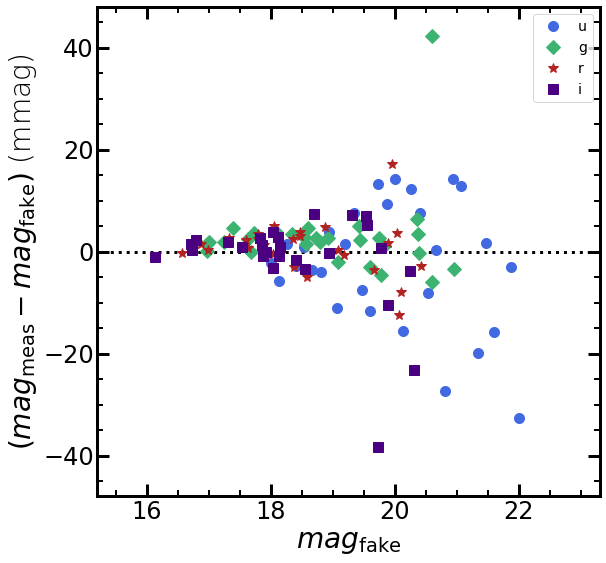

In [30]:
fig = plt.plot(figsize=(9, 9))

plt.hlines(0, 0, 30, linestyle=':', color='Black')
plt.plot(tab_all['u_fake'], 1000.0 * (tab_all['u_meas'] - tab_all['u_fake']),
         'o', ms=10, color='royalblue', label='u')
plt.plot(tab_all['g_fake'], 1000.0 * (tab_all['g_meas'] - tab_all['g_fake']),
         'D', ms=10, color='mediumseagreen', label='g')
plt.plot(tab_all['r_fake'], 1000.0 * (tab_all['r_meas'] - tab_all['r_fake']),
         '*', ms=10, color='firebrick', label='r')
plt.plot(tab_all['i_fake'], 1000.0 * (tab_all['i_meas'] - tab_all['i_fake']),
         's', ms=10, color='indigo', label='i')
plt.legend()
plt.xlabel(r'$mag_{\rm fake}$')
plt.ylabel(r'$(mag_{\rm meas} - mag_{\rm fake})$ (mmag)')
plt.xlim(15.2, 23.3)
plt.ylim(-48, 48)
plt.minorticks_on()
plt.show()

Looks good! (Note that the y-axis is showing residuals in _millimags_.)

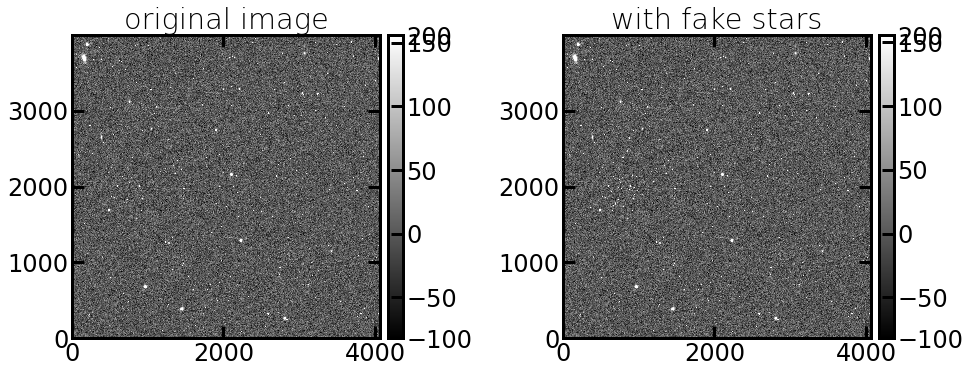

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
plt.sca(ax[0])  # set the first axis as current
display1 = afwDisplay.Display(frame=fig)
display1.scale('linear', 'zscale')
display1.mtv(calexp_orig_g.image)
plt.title('original image')
#plt.xlim(1000, 2500)
#plt.ylim(300, 1800)
plt.sca(ax[1])  # set the second axis as current
display2 = afwDisplay.Display(frame=fig)
display2.scale('linear', 'zscale')
display2.mtv(calexp_new_g.image)
# display2.mtv(image0)
plt.title('with fake stars')
#plt.xlim(1000, 2500)
#plt.ylim(300, 1800)
plt.tight_layout()
plt.show()

Ideas for further exploration:

- Inject stars using a realistic stellar population (i.e., get colors and a luminosity function from isochrones).
- Inject galaxies or other objects.
- Inject periodic variables into a set of overlapping visit images (using their time of observation to determine the input phase, and thus magnitude, for each image).
- Test completeness of detection/measurement (will need to inject stars over a variety of magnitudes and colors, and probably many times over to build up a large enough statistical sample).
